# Flow Matching MNIST

<a target="_blank" href="https://colab.research.google.com/github/cgarciae/simple_flow_matching/blob/main/notebooks/mnist_unet_mixer.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

In [1]:
! pip install -U einop diffrax stop_iter treescope flax
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import numpy as np
from einop import einop
import diffrax
from IPython.display import clear_output
from stop_iter import stop_iter
from tqdm import tqdm
import time

import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml

clear_output()

X.shape = (70000, 28, 28, 1)
Y.shape = (70000,)


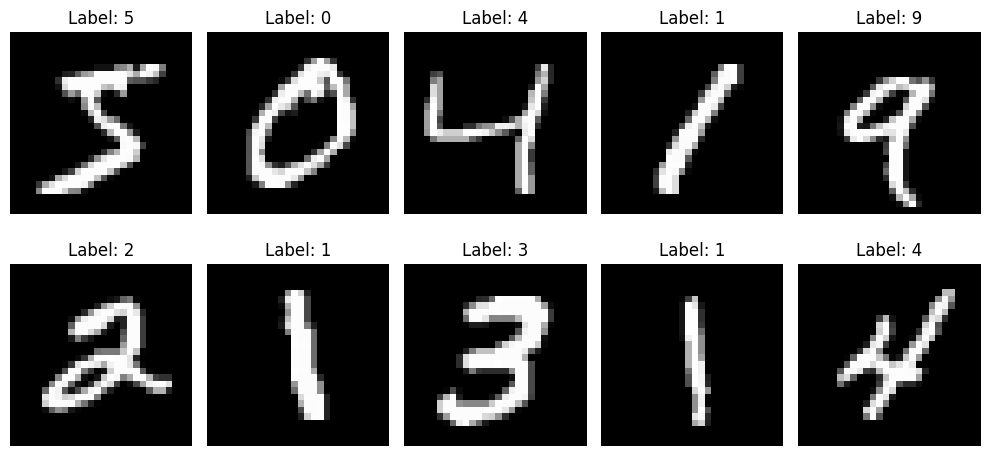

In [2]:
# Load data from openml
mnist = fetch_openml("mnist_784", version=1, cache=True, as_frame=False)

# Extract data and labels
X = mnist.data.astype("uint8").reshape(-1, 28, 28, 1)
Y = mnist.target.astype("uint8")

# Normalize data
X = (X / 255.0) * 2 - 1

print(f"{X.shape = }")
print(f"{Y.shape = }")

fig, axes = plt.subplots(2, 5, figsize=(10, 5))
for i, ax in enumerate(axes.flat):
  ax.imshow(X[i].squeeze(), cmap="gray")
  ax.set_title(f"Label: {Y[i]}")
  ax.axis("off")
plt.tight_layout()
plt.show()

In [3]:
class MlpBlock(nnx.Module):
  def __init__(self, din: int, mlp_dim: int, rngs: nnx.Rngs):
    self.din, self.mlp_dim = din, mlp_dim
    self.linear_in = nnx.Linear(din, mlp_dim, rngs=rngs)
    self.linear_out = nnx.Linear(mlp_dim, din, rngs=rngs)

  def __call__(self, x):
    return self.linear_out(nnx.gelu(self.linear_in(x)))


class MixerBlock(nnx.Module):
  def __init__(
    self, tokens_mlp_dim: int, channels_mlp_dim: int, hidden_dim: int, rngs: nnx.Rngs
  ):
    self.tokens_mlp_dim = tokens_mlp_dim
    self.channels_mlp_dim = channels_mlp_dim
    self.hidden_dim = hidden_dim
    self.token_mixing = MlpBlock(tokens_mlp_dim, hidden_dim, rngs=rngs)
    self.channel_mixing = MlpBlock(channels_mlp_dim, hidden_dim, rngs=rngs)
    self.ln1 = nnx.LayerNorm(channels_mlp_dim, rngs=rngs)
    self.ln2 = nnx.LayerNorm(channels_mlp_dim, rngs=rngs)

  def __call__(self, x):
    y = self.ln1(x)
    y = y.swapaxes(1, 2)
    y = self.token_mixing(y)
    y = y.swapaxes(1, 2)
    x = x + y
    y = self.ln2(x)
    return x + self.channel_mixing(y)

class ScaleTokens(nnx.Module):
  def __init__(self, din: int, dout: int, rngs: nnx.Rngs):
    self.din, self.dout = din, dout
    self.ln = nnx.LayerNorm(din, rngs=rngs)
    self.linear = nnx.Linear(din, dout, rngs=rngs)

  def __call__(self, x):
    x = x.swapaxes(1, 2)
    x = self.ln(x)
    x = self.linear(x)
    return x.swapaxes(1, 2)

class UnetBlock(nnx.Module):
  def __init__(
    self, depth: int, tokens_mlp_dim: int, channels_mlp_dim: int, hidden_dim: int, rngs: nnx.Rngs
  ):
    self.depth = depth
    self.tokens_mlp_dim = tokens_mlp_dim
    self.channels_mlp_dim = channels_mlp_dim
    self.hidden_dim = hidden_dim
    self.mixer_in1 = MixerBlock(tokens_mlp_dim, channels_mlp_dim, hidden_dim, rngs=rngs)
    self.mixer_in2 = MixerBlock(tokens_mlp_dim, channels_mlp_dim, hidden_dim, rngs=rngs)
    self.mixer_out1 = MixerBlock(tokens_mlp_dim, channels_mlp_dim, hidden_dim, rngs=rngs)
    self.mixer_out2 = MixerBlock(tokens_mlp_dim, channels_mlp_dim, hidden_dim, rngs=rngs)
    if depth > 1:
      self.down = ScaleTokens(tokens_mlp_dim, tokens_mlp_dim // 2, rngs=rngs)
      self.unet_block = UnetBlock(depth - 1, tokens_mlp_dim // 2, channels_mlp_dim, hidden_dim, rngs=rngs)
      self.up = ScaleTokens(tokens_mlp_dim // 2, tokens_mlp_dim, rngs=rngs)
    else:
      self.down = None
      self.unet_block = None
      self.up = None

  def __call__(self, x):
    x = self.mixer_in2(self.mixer_in1(x))
    if self.depth > 1:
      assert self.down is not None and self.unet_block is not None and self.up is not None
      y = self.down(x)
      y = self.unet_block(y)
      y = self.up(y)
      x = x + y
    return self.mixer_out2(self.mixer_out1(x))


class Flow(nnx.Module):
  def __init__(
    self,
    din: int,
    kernel_size: tuple[int, int],
    strides: tuple[int, int],
    num_blocks: int,
    hidden_dim: int,
    tokens_mlp_dim: int,
    channels_mlp_dim: int,
    rngs: nnx.Rngs,
  ):
    assert num_blocks % 2 == 0
    self.din = din
    self.kernel_size = kernel_size
    self.num_blocks = num_blocks
    self.hidden_dim = hidden_dim
    self.tokens_mlp_dim = tokens_mlp_dim
    self.channels_mlp_dim = channels_mlp_dim
    self.stem = nnx.Conv(din + 1, channels_mlp_dim, kernel_size=kernel_size, strides=strides, rngs=rngs)
    self.unet = UnetBlock(num_blocks // 2, tokens_mlp_dim, channels_mlp_dim, hidden_dim, rngs=rngs)
    self.pre_head_layer_norm = nnx.LayerNorm(channels_mlp_dim, rngs=rngs)
    self.conv_t = nnx.ConvTranspose(channels_mlp_dim, din, kernel_size=kernel_size, strides=strides, rngs=rngs)

  def __call__(self, *, x, t):
    # add time feature to input
    t = einop(t, "n -> n h w c", h=x.shape[1], w=x.shape[2], c=1)
    x = jnp.concatenate([x, t], axis=-1)
    # create patches
    x = self.stem(x)
    patches_h, patches_w = x.shape[1], x.shape[2]
    x = einop(x, "n h w c -> n (h w) c")
    # apply blocks
    x = self.unet(x)
    # recreate image shape
    x = einop(x, "n (h w) c -> n h w c", h=patches_h, w=patches_w)
    x = self.pre_head_layer_norm(x)
    x = self.conv_t(x)
    return x

  @nnx.jit
  def step(self, x, t_start, t_end):
    solver = diffrax.Midpoint()
    term = diffrax.ODETerm(lambda t, x, args: self(x=x, t=jnp.full(x.shape[0], t)))
    x, _, _, _, _ = solver.step(term, t_start, t_end, x, None, None, made_jump=False)
    return x

rngs = nnx.Rngs(0)
flow = Flow(
  din=1,
  kernel_size=(7, 7),
  strides=(4, 4),
  num_blocks=6,
  hidden_dim=256,
  tokens_mlp_dim=49,
  channels_mlp_dim=128,
  rngs=rngs,
)
lr_schedule = optax.piecewise_constant_schedule(
  init_value=1e-2,
  boundaries_and_scales={33_333: 1e-3, 66_666: 1e-4},
)
optimizer = nnx.Optimizer(flow, tx=optax.adamw(lr_schedule))

dx_t = flow(x=jnp.ones((1, 28, 28, 1)), t=jnp.ones((1,)))
print(f"{dx_t.shape = }")
nnx.display(flow)

dx_t.shape = (1, 28, 28, 1)


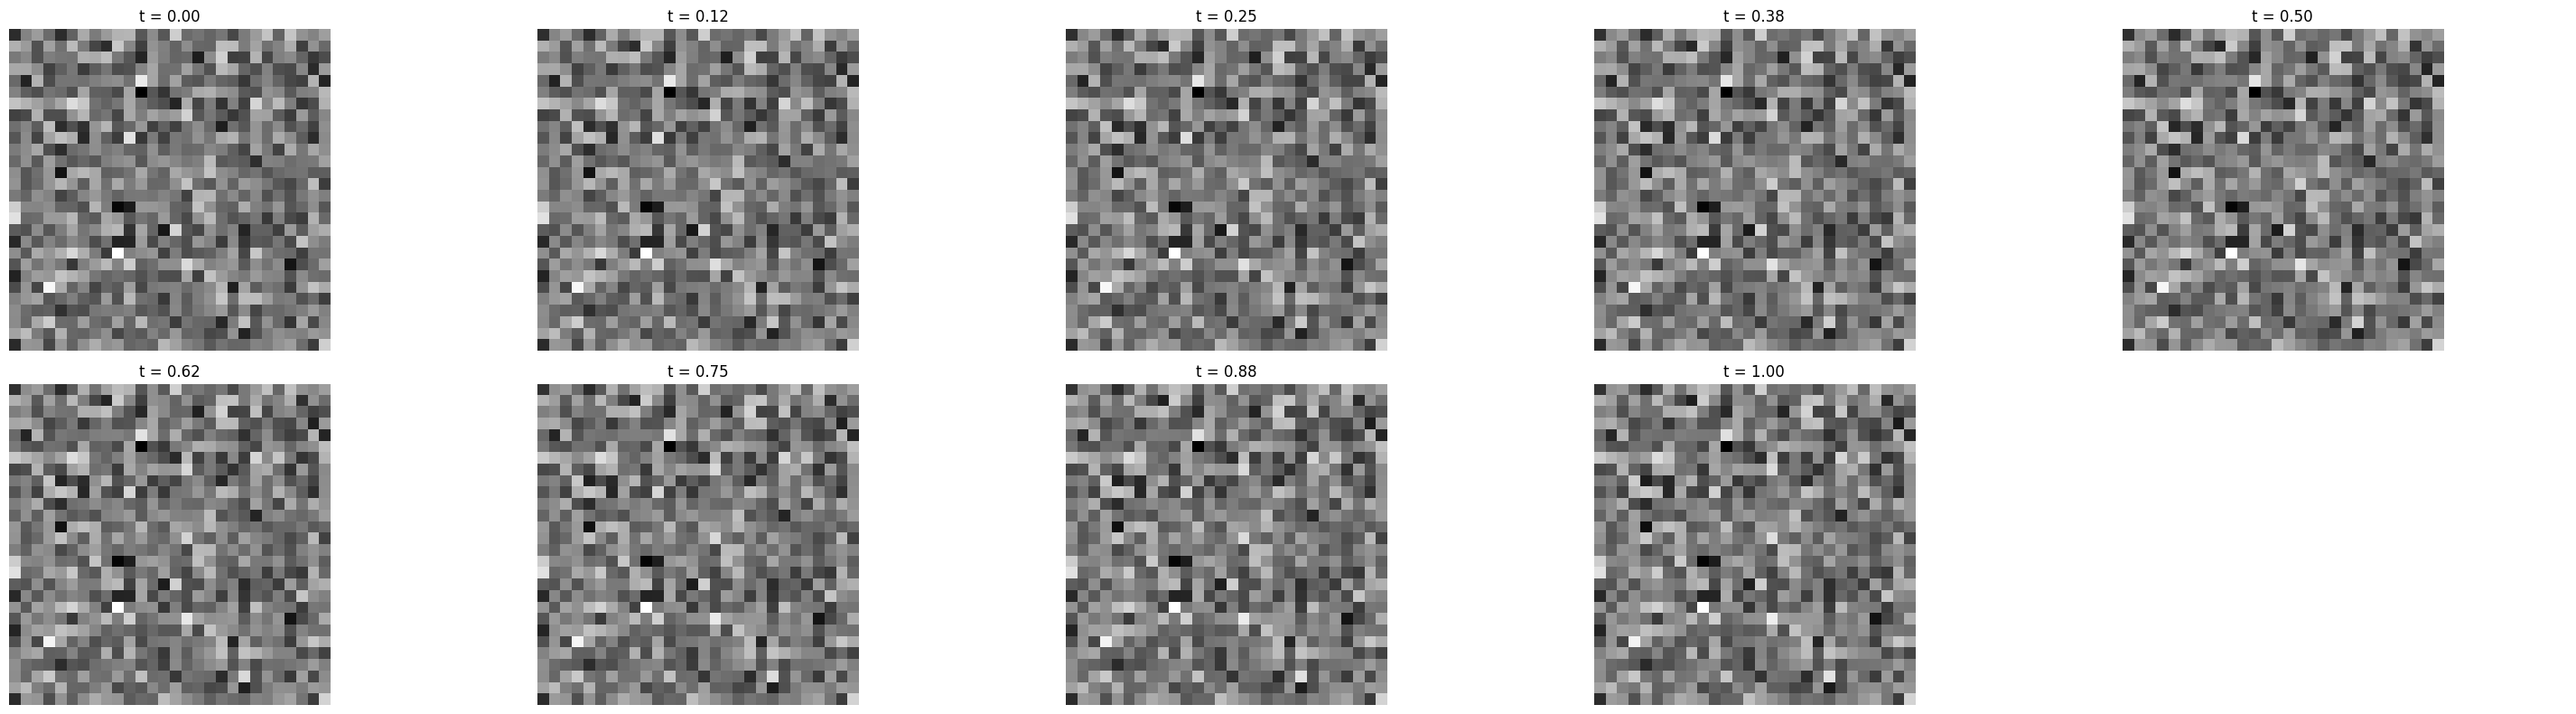

In [4]:
from matplotlib.figure import Figure

def plot_sample(fig: Figure, *, n_steps = 8):
  x = np.random.randn(1, *X.shape[1:])

  axes = fig.subplots(2, (n_steps) // 2 + 1, sharex=True, sharey=True)
  time_steps = np.linspace(0, 1.0, n_steps + 1)

  for i, ax in enumerate(axes.flat):
    if i == 0:
      ax.imshow(x.squeeze(), cmap="gray")
      ax.set_title(f"t = {time_steps[0]:.2f}")
    elif i <= n_steps:
      x = flow.step(x=x, t_start=time_steps[i - 1], t_end=time_steps[i])
      ax.imshow(x.squeeze(), cmap="gray")
      ax.set_title(f"t = {time_steps[i]:.2f}")
    ax.axis("off")

  fig.tight_layout()


plot_sample(plt.figure(figsize=(30, 8)))
plt.show()

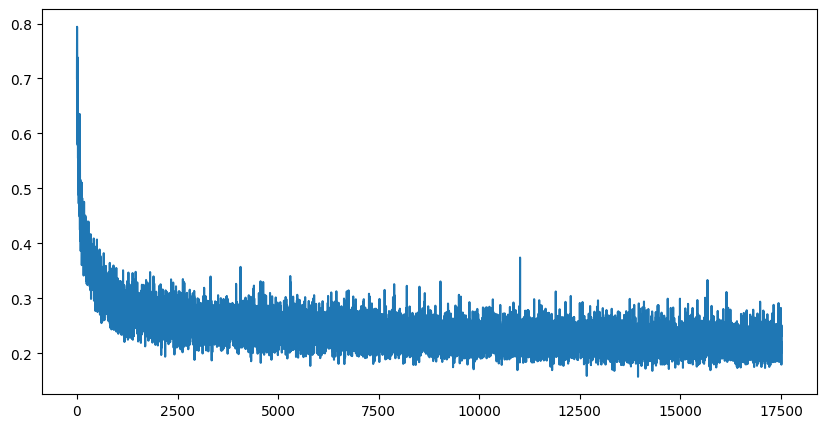

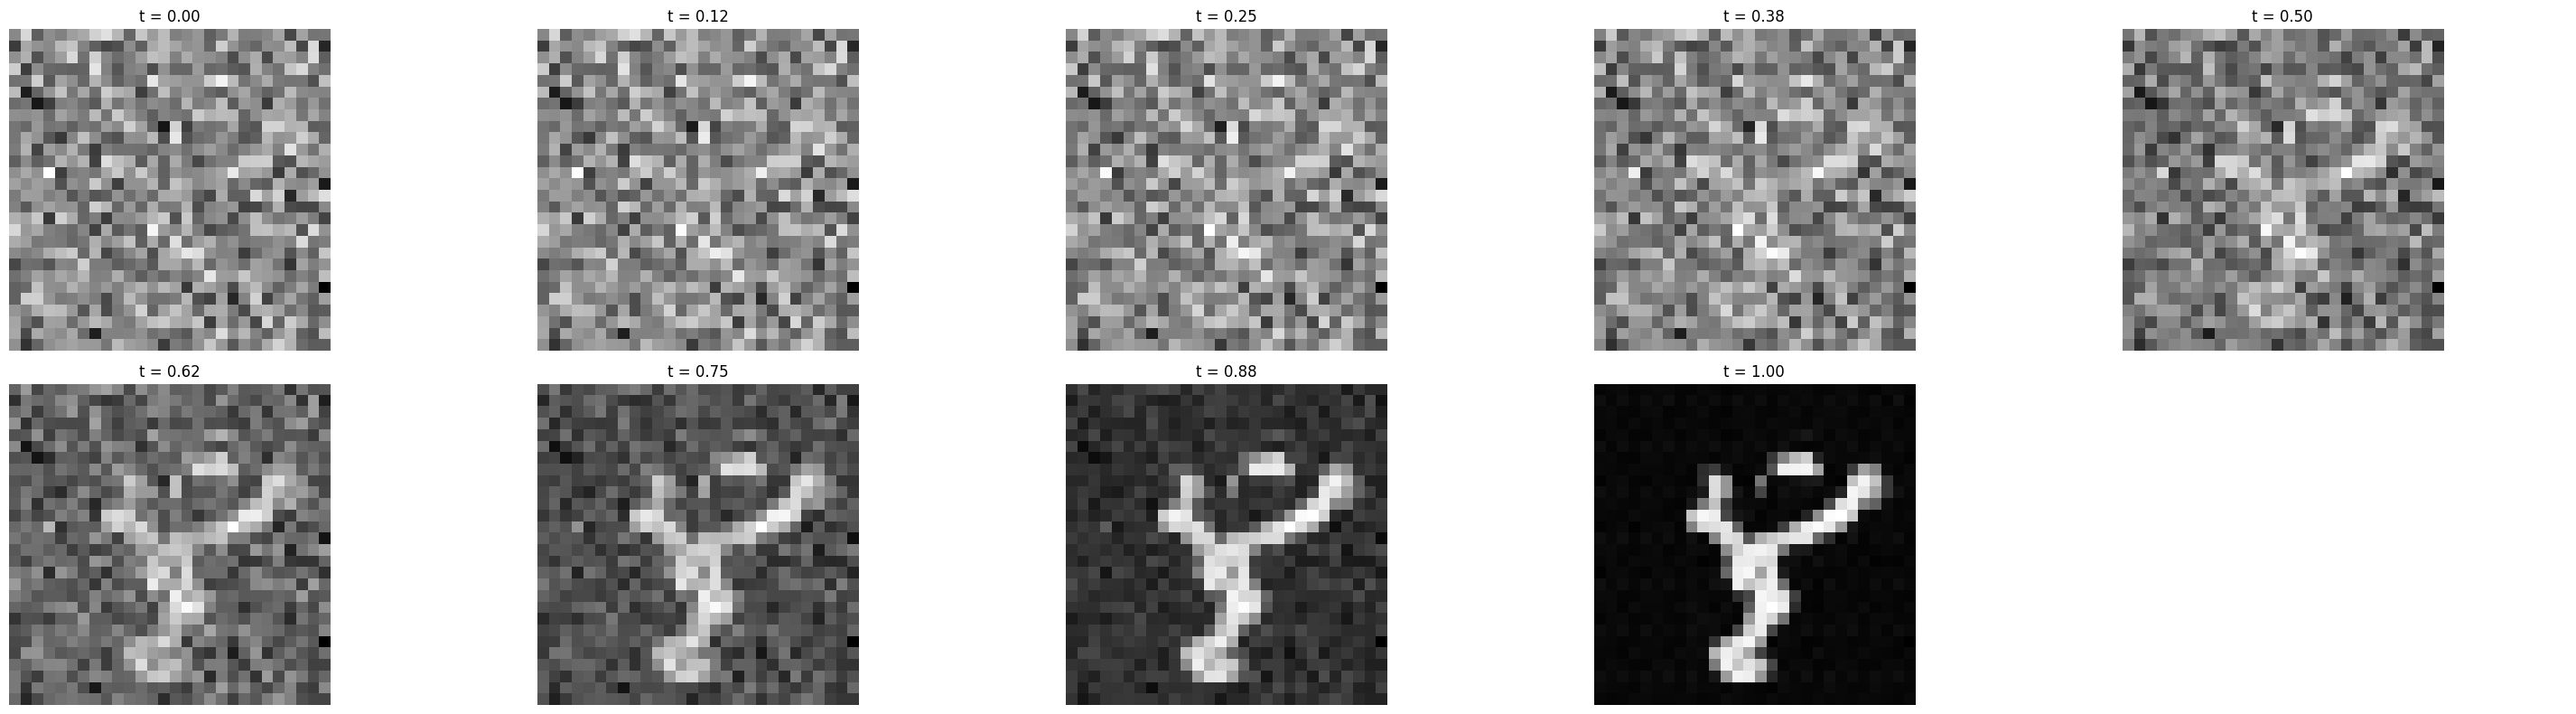

 18%|█▊        | 17732/100000 [08:16<28:38, 47.86it/s]

In [ ]:
mse = lambda a, b: jnp.mean((a - b) ** 2)

@nnx.jit(donate_argnums=(0, 1, 2))
def train_step(flow, optimizer, rngs, x_1):
  x_0 = jax.random.normal(rngs(), x_1.shape)
  t = jax.random.uniform(rngs(), (len(x_1),))

  x_t = jax.vmap(lambda x_0, x_1, t: (1 - t) * x_0 + t * x_1)(x_0, x_1, t)
  dx_t = x_1 - x_0

  loss, grads = nnx.value_and_grad(lambda flow: mse(flow(x=x_t, t=t), dx_t))(flow)
  optimizer.update(grads)
  return loss


losses = []
plot_interval = 60
t0 = time.time()
for step in stop_iter(tqdm(range(100_000))):
  x_1 = X[np.random.choice(len(X), 32)]
  loss = train_step(flow, optimizer, rngs, x_1)
  losses.append(np.asarray(loss))
  if step == 0 or time.time() - t0 >= plot_interval:
    # plot loss
    clear_output(wait=True)
    fig = plt.figure(figsize=(10, 5))
    t0 = time.time()
    plt.plot(losses[100:])
    # plot samples
    plot_sample(plt.figure(figsize=(30, 8)))
    plt.show()

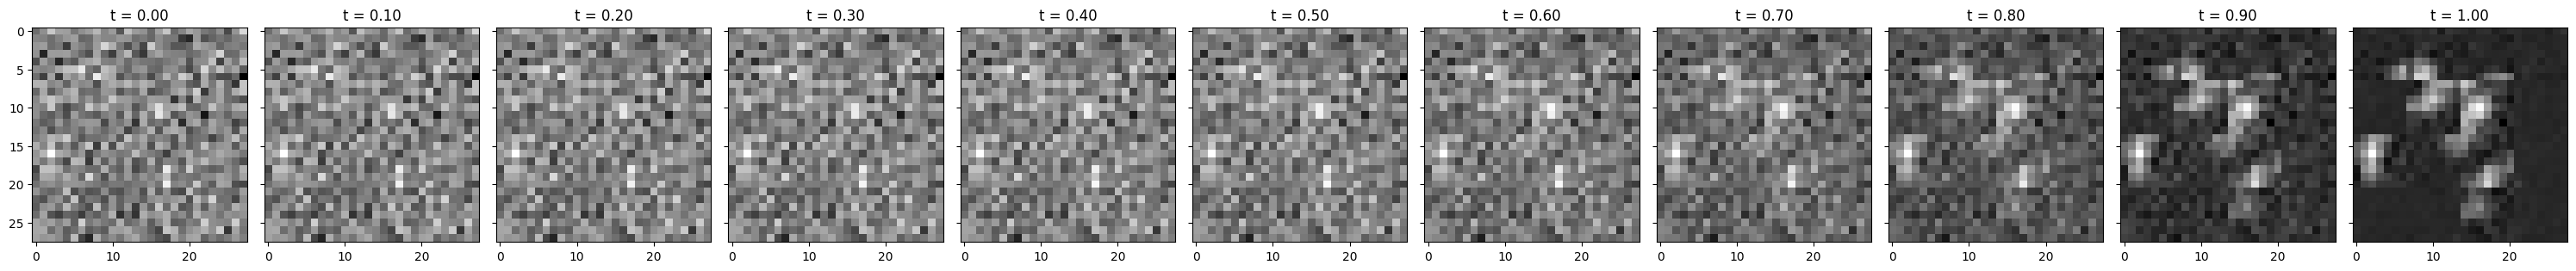

In [ ]:
plot_sample(plt.figure(figsize=(30, 8)), n_steps=16)
plt.show()